#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

#### This notebook does not include the raw data files. In order to run the notebook, you need to download them from https://fastmri.med.nyu.edu/

In [6]:
%matplotlib inline

import h5py
import dotenv
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

In [4]:
dotenv.load_dotenv()

SINGLECOIL_TRAIN_PATH = os.environ.get('SINGLECOIL_TRAIN_PATH')
SINGLECOIL_VAL_PATH = os.environ.get('SINGLECOIL_VAL_PATH')

print(f'SINGLECOIL_TRAIN_PATH: {SINGLECOIL_TRAIN_PATH}')
print(f'SINGLECOIL_VAL_PATH: {SINGLECOIL_VAL_PATH}')


SINGLECOIL_TRAIN_PATH: /media/alek/nas1/projects/fastmri/knee/knee_singlecoil_val/singlecoil_train
SINGLECOIL_VAL_PATH: /media/alek/nas1/projects/fastmri/knee/knee_singlecoil_val/singlecoil_val


The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [7]:
train_files = glob.glob(os.path.join(SINGLECOIL_TRAIN_PATH, '*.h5'))

# file_name = 'multicoil_train/file1000167.h5'
# file_name = '/Users/rohitkapoor/Downloads/singlecoil_train/file1002073.h5'
file_name = train_files[0]
hf = h5py.File(file_name)

In [8]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPD_FBK', 'max': np.float64(0.00026584269641545375), 'norm': np.float64(0.11993773816645464), 'patient_id': '01baeadd109d08e8f465b650c365a974ef2bcf7ef49a150af0a87073819a7a7e'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [9]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(34, 640, 372)


In [10]:
# slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume
slice_kspace = volume_kspace 

Let's see what the absolute value of k-space looks like:

In [11]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

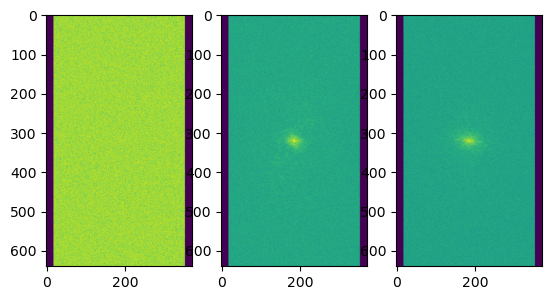

In [12]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [13]:
import fastmri
from fastmri.data import transforms as T

In [14]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

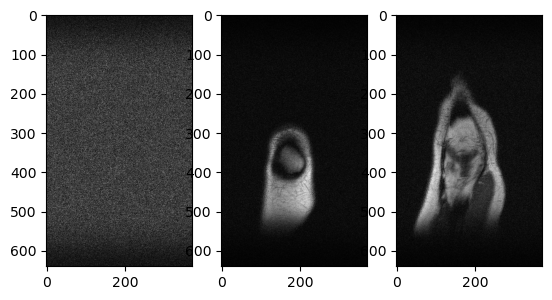

In [15]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [16]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

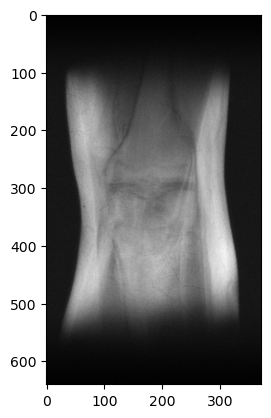

In [17]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [20]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [21]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

In [28]:
print(masked_kspace.shape)
print(mask.shape)

torch.Size([34, 640, 372, 2])
torch.Size([1, 1, 372, 1])


Let's plot the masked kspace

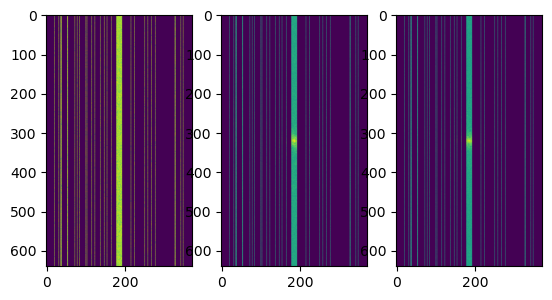

In [27]:
masked_kspace_complex = T.tensor_to_complex_np(masked_kspace)
show_coils(np.log(np.abs(masked_kspace_complex) + 1e-9), [0, 5, 10])

Let's see what the subsampled image looks like:

In [22]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

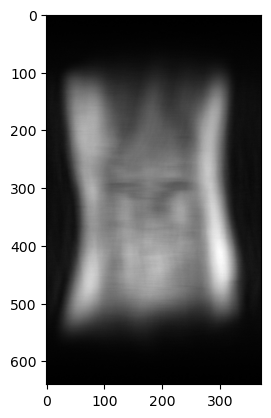

In [23]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')